In [1]:
import alpaca_trade_api as tradeapi
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from ta.trend import macd, macd_signal
import time
from ipywidgets import *
import PyQt5

In [2]:
# %matplotlib widget
# %matplotlib qt
# %matplotlib notebook
# %matplotlib inline
# plt.plot(tsla.index, tsla['close'])
# plt.show()

<IPython.core.display.Javascript object>


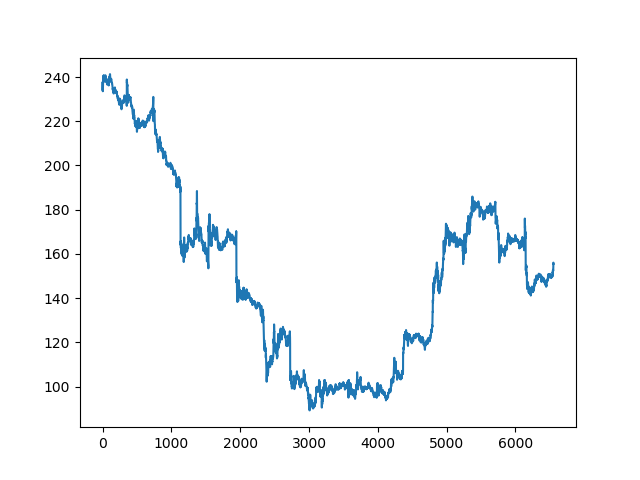

<IPython.core.display.Javascript object>


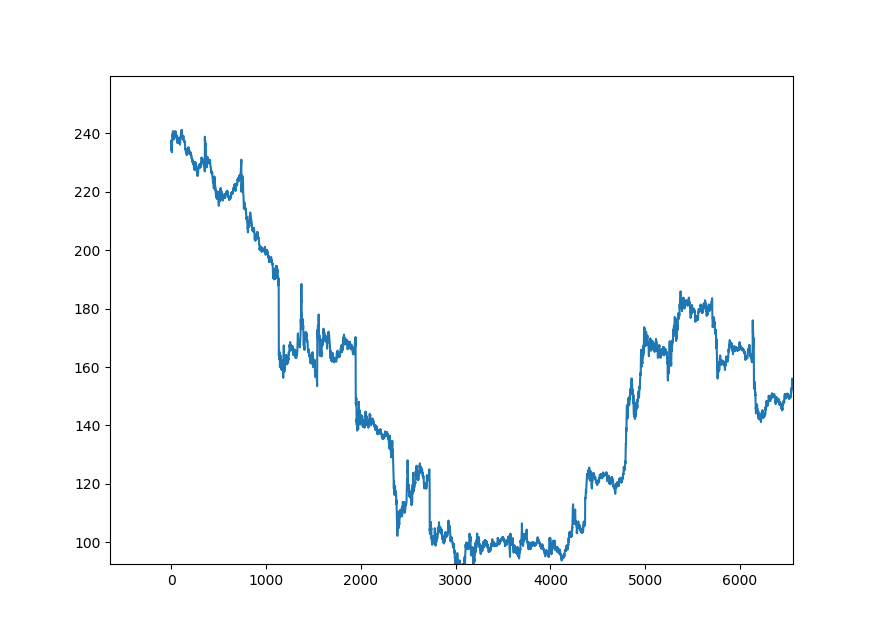

In [13]:
# %matplotlib qt
# %matplotlib inline
%matplotlib notebook
# %matplotlib notebook
# %matplotlib widget
# %matplotlib
plt.figure()
plt.plot(tsla.index, tsla['close'])
plt.figure()
plt.plot(tsla.index, tsla['close'])
# plt.show()


In [4]:
APCA_API_BASE_URL = "https://paper-api.alpaca.markets"
APCA_API_KEY_ID = "PKG8YJEN7J4G065QVA9K"
APCA_API_SECRET_KEY = "VzWRlCAtrvEGsQGKJGtWRXEswk442vpR4fJJeLIw"
api = tradeapi.REST(base_url=APCA_API_BASE_URL, key_id=APCA_API_KEY_ID, secret_key=APCA_API_SECRET_KEY)
account = api.get_account()
account.status

'ACTIVE'

In [5]:
if account.trading_blocked:
    print('Account is currently restricted from trading.')

In [6]:
clock = api.get_clock()
clock

Clock({   'is_open': False,
    'next_close': '2021-01-21T16:00:00-05:00',
    'next_open': '2021-01-21T09:30:00-05:00',
    'timestamp': '2021-01-21T03:20:26.131118158-05:00'})

In [7]:
for symbol in stocks:
    order = api.submit_order(
        symbol = symbol,
        qty = '1',
        side = 'buy',
        type = 'market',
        time_in_force = 'gtc')
    # order
    api.get_portfolio_history()

NameError: name 'stocks' is not defined

In [ ]:
api.list_orders()
# api.cancel_all_orders()

In [ ]:
api.list_positions()
# api.get_portfolio_history()

In [ ]:
for order in api.list_orders():
    if (order.symbol) == 'BABA':
        oid, qty = order.id, order
        api.submit_order(
        symbol = 'BABA',
        qty = '2',
        side = 'buy',
        type = 'market',
        time_in_force = 'gtc')

In [ ]:
api.cancel_order(api.list_orders()[0].id)

In [ ]:
def convert_time_to_num_minute(timestamp):
    return int(''.join(str(timestamp).split()[1].split(':')[:3])[:6])
convert_time_to_num_minute(clock.timestamp)
# clock.timestamp

In [ ]:
clock

In [ ]:
['Time'] + list(tsla.columns[1:])

In [8]:
tsla = api.get_barset('WMT', 'minute',limit = 300).df
def process_stock_df(df):
    df.reset_index(inplace=True)
    df.columns = df.columns.droplevel()
    df.columns = ['Time'] + list(df.columns[1:])
process_stock_df(tsla)
# tsla.rolling(window=20).mean()

In [ ]:
def SMA(df, cnts = 20, add_col = True):
    if df.shape[0] < cnts: raise "Not enought data to calculate moving averages!"
    data = df['close'].rolling(window=cnts).mean()
    if add_col:
        df['SMA'+str(cnts)] = data
    return data

def Bollinger_Band(df, cnts = 20, add_col = True):
    if df.shape[0] < cnts: raise "Not enought data to calculate moving averages!"
    bbMid = SMA(df, cnts)
    std = df['close'].rolling(window=cnts).std()
    bbHigh = bbMid + std*2
    bbLow = bbMid - std*2
    if add_col:
        df['bbHigh'], df['bbMid'], df['bbLow'] = bbHigh, bbMid, bbLow
    return bbHigh, bbMid, bbLow


In [ ]:
SMA(tsla, 50,  True)

In [ ]:
Bollinger_Band(tsla, 20, True)
tsla#.iloc[100:200]

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(tsla['Time'], tsla[['bbHigh', 'bbMid', 'bbLow']])
plt.plot(tsla['Time'], tsla[['close']])
plt.grid()
plt.show()

In [ ]:
def MACD(df, sp1=12, sp2=26, sp3=9, add_col = True):
#     tsla['close'].ewm(span=12, adjust=False).mean()
#     df = tsla['close']
    data = df['close']
    exp1 = data.ewm(span=12, adjust=False).mean()
    exp2 = data.ewm(span=26, adjust=False).mean()
    macd = exp1-exp2
    exp3 = macd.ewm(span=9, adjust=False).mean()   
    if add_col:
        df['MACD_fast'] = macd
        df['MACD_slow'] = exp3
        df['MACD_diff'] = macd-exp3
    return macd, exp3, macd-exp3

MACD(tsla)


def linreg(A, B):
    A = np.array(A).reshape((-1, 1))
    B = np.array(B)
    lr_model = LinearRegression().fit(A,B)
    return lr_model.coef_[0], lr_model.intercept_



NEXT:
    1. multithread kill学会，以及lock进行买卖操作，以便用来以后每个thread监控一只股票
    2. 买单和卖单对应实现，并学会如何高效地映射到对应单的id进行卖出。因为你使用了多个strategy操盘
    3. 用历史股价复盘现在的MACD+BB+SMA买卖策略，建议挑几个熊市的日间数据来复盘
    

In [ ]:
tsla['buyin'] = [np.nan] * tsla.shape[0]
tsla['sellout'] = [np.nan] * tsla.shape[0]
# tsla[not i for i in tsla['buyin'].isnull()]
# for item in tsla['buyin']:
#     if not pd.isna(item): pass

In [ ]:
tsla['buyin'].isnull().unique()

In [ ]:
# %matplotlib inline
# %matplotlib qt
# %matplotlib notebook 
tsla['buyin'] = [np.nan] * tsla.shape[0]
tsla['sellout'] = [np.nan] * tsla.shape[0]

stock = 0
res = 0
lag_buy = 5
diff_threshold_buy = 0.02
macd_boundry_buy = 0
lag_sell = 2
diff_threshold_sell = 0.005
macd_boundry_sell = 0
buyin = []
for i in range(max(lag_buy, lag_sell), tsla.shape[0]):
    if tsla.iloc[i-lag_buy]['MACD_diff'] < 0 and \
        tsla.iloc[i]['MACD_diff'] > 0 and \
        tsla.iloc[i]['MACD_fast'] > macd_boundry_buy and \
        abs(tsla.iloc[i]['MACD_diff']) > diff_threshold_buy: 
            stock += 1
            buyin.append(tsla.iloc[i]['close'])
            tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
            print(i, 'in', tsla.iloc[i]['close'], tsla.iloc[i]['Time'], tsla.iloc[i]['buyin'])
    elif tsla.iloc[i-lag_sell]['MACD_diff'] < 0 and \
        abs(tsla.iloc[i]['MACD_diff']) > diff_threshold_sell and stock: 
#         tsla.iloc[i-lag_sell]['MACD_diff'] > 0 and \
#         tsla.iloc[i]['MACD_diff'] < 0 and \
            tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
            res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin])
            buyin = []
            stock = 0
            print(i, 'out', tsla.iloc[i]['close'], tsla.iloc[i]['Time'], tsla.iloc[i]['sellout'])
print(res)

plt.figure(figsize=(12,8))
plt.plot(tsla['Time'], tsla['MACD_fast'], marker='.', label='fast')
plt.plot(tsla['Time'], tsla['MACD_slow'], marker='.', label='slow')
plt.plot(tsla['Time'], tsla['MACD_diff'], marker='.', label='diff')

plt.legend(loc='upper left')
plt.grid()

plt.figure(figsize=(12,8))
plt.plot(tsla['Time'], tsla['close'], label='Price')
plt.plot(tsla['Time'], tsla['buyin'], 'o', label='buy')
plt.plot(tsla['Time'], tsla['sellout'], 'o', label='sell')
plt.legend(loc='upper left')
plt.grid()
plt.show()

# tsla.iloc[30:40]

In [ ]:
def buyin_strategy(tsla, i, lag_buy = 5, diff_threshold_buy = 0.1, macd_boundry_buy = -5, sma20_gradient = 0.001):
    return tsla.iloc[i-lag_buy]['MACD_diff'] < 0 and \
       tsla.iloc[i]['MACD_diff'] > 0 and \
        tsla.iloc[i]['MACD_fast'] > macd_boundry_buy and \
        abs(sum(tsla.iloc[i-lag_buy : i]['MACD_diff'])/lag_buy) > diff_threshold_buy and\
        (tsla.iloc[i]['SMA20'] - tsla.iloc[i-lag_buy]['SMA20']) / tsla.iloc[i]['SMA20'] > sma20_gradient

In [ ]:
def sell_strategy(tsla, i, last_buyin, lag_sell = 2, stoploss_rate = 0.025, diff_threshold_sell = 0.0005, macd_boundry_sell = 0):
    return (tsla.iloc[i]['close'] < last_buyin*(1 - stoploss_rate)) or \
        (tsla.iloc[i-lag_sell]['MACD_diff'] < 0 and \
        abs(tsla.iloc[i]['MACD_diff']) > diff_threshold_sell)

In [ ]:
def buyin_strategy_bb(df, i, change_rate = -0.003, lag_buy = 5, diff_threshold_buy = 0.1, macd_boundry_buy = -5, sma20_gradient = 0.001):
    return  any([df.loc[i, fom] < df.loc[i, 'bbLow'] for fom in ['close', 'low', 'high', 'open']]) and \
             (df.loc[i, 'close'] - df.loc[i-1, 'close']) / df.loc[i, 'close'] > change_rate
        
def sell_strategy_bb(df, i, last_buyin, lag_sell = 2, stoploss_rate = 0.025, diff_threshold_sell = 0.0005, macd_boundry_sell = 0):
    return (df.iloc[i]['close'] < last_buyin*(1 - stoploss_rate)) or \
            (df.loc[i-1, 'SMA5'] >= df.loc[i-1, 'SMA20'] and df.loc[i, 'SMA5'] < df.loc[i, 'SMA20']) or\
            (df.loc[i-1, 'close'] > df.loc[i, 'bbHigh'] and df.loc[i, 'close'] < df.loc[i, 'bbHigh'])

In [ ]:
def normalize_macd(macd_diff, stock_price): 
    return macd_diff * 100 / stock_price

def linreg(A, B):
    A = np.array(A).reshape((-1, 1))
    B = np.array(B)
    lr_model = LinearRegression().fit(A,B)
    return lr_model.coef_[0], lr_model.intercept_

def is_macd_trend_opposite_from_stock_value(df, i, span = 7):
    stock_val = df.loc[i-span : i, 'close']
    macd = df.loc[i-span : i, 'MACD_fast']
    return linreg(range(len(stock_val)), stock_val)[0] < 0 and  linreg(range(len(macd)), macd)[0] > 0

def buyin_strategy_combined_v2(df, i, lag_buy = 5, 
                            diff_threshold_buy = 0.08, macd_boundry_buy = -5, sma20_gradient_macd = -0.005, 
                            sma20_gradient_bb = -0.008, sma5_gradient_bb = -0.002, close_gradient_bb = 0.005,
                            macd_weight = 0.45, bb_weight = 0.55):
    main_factor_macd = 1 if df.iloc[i-lag_buy]['MACD_diff'] < 0 and df.iloc[i]['MACD_diff'] > 0 else 0
    main_factor_bb = 1 if any([df.loc[j, 'close'] < df.loc[j, 'bbLow'] for j in range(i-lag_buy, i+1)]) else 0

    sub_factors_macd = []
    sub_factors_bb = []
    
    sub_factors_macd.append(is_macd_trend_opposite_from_stock_value(df, i, span = 10))
    sub_factors_macd.append(df.iloc[i]['bbHigh'] > df.iloc[i]['close'])
    sub_factors_macd.append(normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) > diff_threshold_buy)
    sub_factors_macd.append(normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) > diff_threshold_buy and \
                           normalize_macd(df.iloc[i-1]['MACD_diff'], df.iloc[i-1]['close']) < diff_threshold_buy)
    sub_factors_macd.append(linreg(np.arange(10), df.iloc[i-10:i]['SMA20'])[0]  > sma20_gradient_macd)
    
    sub_factors_bb.append(linreg(np.arange(10), df.iloc[i-10:i]['SMA20'])[0]  > sma20_gradient_bb)
    sub_factors_bb.append((df.iloc[i]['SMA5'] - df.iloc[i-1]['SMA5']) / df.iloc[i]['SMA5'] > sma5_gradient_bb)
    sub_factors_bb.append((df.loc[i, 'close'] - min(df.iloc[i-lag_buy:i]['close'])) / df.loc[i, 'close'] > close_gradient_bb)

    return  macd_weight * main_factor_macd * sum(sub_factors_macd)/len(sub_factors_macd) +  bb_weight * main_factor_bb * sum(sub_factors_bb)/ len(sub_factors_bb)

def sell_strategy_combined_v2(df, i, cost_basis, lag_sell = 2, stoploss_rate = 0.025, 
                           diff_threshold_sell = -0.08, bb_high_stop_loss_rate = -0.005):
    if df.iloc[i]['close'] < cost_basis*(1 - stoploss_rate): return 1000
    sell_factors = []
    sell_factors.append(tsla.iloc[i-lag_sell]['MACD_diff'] > 0 and tsla.iloc[i]['MACD_diff'] < 0)
    sell_factors.append(normalize_macd(tsla.iloc[i]['MACD_diff'], tsla.iloc[i]['close']) < diff_threshold_sell)
    sell_factors.append(df.loc[i-lag_sell, 'SMA5'] >= df.loc[i-lag_sell, 'SMA20'] and df.loc[i, 'SMA5'] < df.loc[i, 'SMA20']) 
    sell_factors.append(df.loc[i-lag_sell, 'close'] > df.loc[i-lag_sell, 'bbHigh'] and df.loc[i, 'close'] < df.loc[i, 'bbHigh'])
    sell_factors.append((df.loc[i-max(lag_sell,5), 'close'] > df.loc[i-max(lag_sell,5), 'bbHigh'] and \
                        (df.loc[i, 'close'] - df.loc[i, 'bbHigh']) / df.loc[i, 'close'] < bb_high_stop_loss_rate))
    return sum(sell_factors)/len(sell_factors)

In [ ]:
def normalize_macd(macd_diff, stock_price): 
    pwr_coeff = np.log(21)/ np.log(30) #基于最离谱的亚马逊股价计算，发现其比较合理的shrink值为比线性值稍低，这里取25/30，日后可调
    return macd_diff * 1 / np.power(stock_price/100, pwr_coeff)

def linreg(A, B):
    A = np.array(A).reshape((-1, 1))
    B = np.array(B)
    lr_model = LinearRegression().fit(A,B)
    return lr_model.coef_[0], lr_model.intercept_

def trend_strategy(df, i, lag_buy = 10, analysis_span = 12, diff_threshold_buy = 0.08, sma30_gradient_trend = 0.004,
                    sma20_gradient_trend = 0.07, sma10_gradient_trend = 0.01, sma_fast_over_slow_ratio_trend = 0.012,
                    close_gradient_bb = 0.015):
    sub_factors_trend = []
    if linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA30'])[0] > sma30_gradient_trend and \
    normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) > diff_threshold_buy and \
    not macd_strategy(df, i, lag_buy = 10)[0]:
        main_factor_trend = 1 
    else:
        main_factor_trend = 0
    
    sub_factors_trend.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA20'])[0] > sma20_gradient_trend)
    sub_factors_trend.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA10'])[0] > sma10_gradient_trend)
    sub_factors_trend.append((df.iloc[i]['SMA5'] - df.iloc[i]['SMA30']) / df.iloc[i]['SMA30'] > sma_fast_over_slow_ratio_trend)
    sub_factors_trend.append((df.iloc[i]['close'] - min(df.iloc[i-analysis_span:i]['close'])) / df.iloc[i]['close']  > close_gradient_bb)
    sub_factors_trend.append(df.iloc[i]['SMA5']  > df.iloc[i]['SMA10'] and df.iloc[i]['SMA10']  > df.iloc[i]['SMA20'] and \
                             df.iloc[i]['SMA20']  > df.iloc[i]['SMA30'])
    return True if main_factor_trend and sum(sub_factors_trend) >=len(sub_factors_trend) - 1 else False, \
                     main_factor_trend, sub_factors_trend
        

def macd_strategy(df, i, lag_buy = 10, diff_threshold_buy = 0.08, analysis_span = 12,
                  sma30_gradient_macd = -0.002, sma10_gradient_macd = 0.003, sma_fast_over_slow_ratio = 0.005):
        sub_factors_macd = []
        main_factor_macd = 1 if any(df.iloc[i-lag_buy:i]['MACD_diff'] < 0) and df.iloc[i]['MACD_diff'] > 0 else 0
        
        sub_factors_macd.append(normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) > diff_threshold_buy)
        sub_factors_macd.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA20'])[0] > sma30_gradient_macd)
        sub_factors_macd.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA5'])[0] > sma10_gradient_macd)
        sub_factors_macd.append(df.iloc[i-analysis_span]['SMA5'] < df.iloc[i-analysis_span]['SMA30'] and \
                                (df.iloc[i]['SMA5'] - df.iloc[i]['SMA30']) / df.iloc[i]['SMA30'] > sma_fast_over_slow_ratio)
        return True if main_factor_macd and sum(sub_factors_macd) >=len(sub_factors_macd) - 1 else False, \
                         main_factor_macd, sub_factors_macd
    
def bb_strategy(df, i, lag_buy = 11, diff_threshold_buy = 0.08 , analysis_span = 12,
                sma30_gradient_bb = -0.008, sma10_gradient_bb = 0.001, close_gradient_bb = 0.005):
    sub_factors_bb = []
    main_factor_bb = 1 if any([df.loc[j, 'close'] < df.loc[j, 'bbLow'] for j in range(i-lag_buy, i+1)]) else 0

    sub_factors_bb.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA20'])[0]  > sma30_gradient_bb)
    sub_factors_bb.append(linreg(np.arange(analysis_span), df.iloc[i-analysis_span:i]['SMA5'])[0]  > sma10_gradient_bb)
    sub_factors_bb.append((df.iloc[i]['close'] - min(df.iloc[i-analysis_span:i]['close'])) / df.iloc[i]['close']  > close_gradient_bb)
    sub_factors_bb.append(df.iloc[i]['SMA5']  > df.iloc[i]['SMA10'] and df.iloc[i]['SMA10']  > df.iloc[i]['SMA20'] and \
                          df.iloc[i]['SMA20']  > df.iloc[i]['SMA30'])
    sub_factors_bb.append(normalize_macd(df.iloc[i]['MACD_diff'], df.iloc[i]['close']) > diff_threshold_buy)
    return True if main_factor_bb and sum(sub_factors_bb) >=len(sub_factors_bb) - 1 else False, \
            main_factor_bb, sub_factors_bb

def buyin_strategy_combined_v4(df, i, lag_buy = 10):
#                             diff_threshold_buy = 0.08, macd_boundry_buy = -5, sma30_gradient_macd = -0.005,sma10_gradient_macd = 0.003, \
#                             sma30_gradient_bb = -0.008, sma10_gradient_bb = 0.001, close_gradient_bb = 0.005,
#                             macd_weight = 0.5, bb_weight = 0.5, analysis_span = 10):
    
    macd_res, main_factor_macd, sub_factors_macd = macd_strategy(df, i, lag_buy)
    macd_val = 0.5 if macd_res and not macd_strategy(df, i-1, lag_buy)[0] else 0
    bb_res, main_factor_bb, sub_factors_bb = bb_strategy(df, i, lag_buy+1)
    bb_val = 0.5 if bb_res and not bb_strategy(df, i-1, lag_buy)[0] else 0
    trend_res, main_factor_trend, sub_factors_trend = trend_strategy(df, i, lag_buy+1)
    trend_val = 0.5 if trend_res and not trend_strategy(df, i-1, lag_buy)[0] else 0
    
    return  macd_val + bb_val + trend_val, main_factor_macd, sub_factors_macd, main_factor_bb, sub_factors_bb, \
             main_factor_trend, sub_factors_trend
        

def sell_strategy_combined_v4(df, i, cost_basis, lag_sell = 2, stoploss_rate = 0.01, \
                           diff_threshold_sell = -0.05, bb_high_stop_loss_rate = -0.01):
    if df.iloc[i]['close'] < cost_basis*(1 - stoploss_rate): return 100
    else: return 0
#     sell_factors = []
#     if not bb_strategy(df, i, lag_buy=15)[0]:
#         sell_factors.append(normalize_macd(tsla.iloc[i]['MACD_diff'], tsla.iloc[i]['close']) < diff_threshold_sell)
#     sell_factors.append(tsla.iloc[i-lag_sell]['MACD_diff'] > 0 and tsla.iloc[i]['MACD_diff'] < 0)
#     sell_factors.append(df.loc[i-lag_sell, 'SMA10'] >= df.loc[i-lag_sell, 'SMA30'] and df.loc[i, 'SMA10'] < df.loc[i, 'SMA30']) 
#     sell_factors.append(df.loc[i-lag_sell, 'close'] > df.loc[i-lag_sell, 'bbHigh'] and df.loc[i, 'close'] < df.loc[i, 'bbHigh'])
#     sell_factors.append(df.loc[i-max(lag_sell,5), 'close'] > df.loc[i-max(lag_sell,5), 'bbHigh'] and \
#                         ((df.loc[i, 'close'] - df.loc[i, 'bbHigh']) / df.loc[i, 'close'] < bb_high_stop_loss_rate or \
#                         df.loc[i, 'close'] < cost_basis))
#     return float(sum(sell_factors)/len(sell_factors))#, sell_factors


In [ ]:
symbols = ['VLDR', 'WMT', 'BA', 'AAPL', 'TDOC', 'NIO', 'FB', 'MSFT', 'BABA', 'AMD', 'V', 'JPM', 'TSLA', 'BAC', 'CCL',
         'NVDA', 'DOCU', 'CRM', 'PYPL', 'U', 'PLUG', 'ZM', 'GOOG', 'AMZN', 'UAL', 'OXY', 'ARKQ', 'DASH', 'ABNB', 'CRON']  
symbols = ['ZM', 'CCL', 'BABA', 'DOCU', 'CRON']

highest_prices = {}
for symbol in symbols:
    highest_prices[symbol] = 0

revenue = 0
for symbol in symbols:
    print(symbol)
#     tsla = api.get_barset(symbol, '5Min', start = '2021-01-01T11:00:00-05:00', end = '2021-01-15T16:00:00-05:00').df
    tsla = api.get_barset(symbol, '5Min', start = '2019-04-14T9:00:00-05:00', end = '2019-05-14T16:00:00-05:00').df
    if tsla.shape[0] < 60: continue
    process_stock_df(tsla)
    SMA(tsla, 5,  True)
    SMA(tsla, 10,  True)
    SMA(tsla, 20,  True) 
    SMA(tsla, 30,  True)
    Bollinger_Band(tsla, 20, True)
    MACD(tsla)

    data = tsla['close']
    EMA12 = data.ewm(span=12, adjust=False).mean()
    EMA26 = data.ewm(span=26, adjust=False).mean()
    tsla['EMA12'] = EMA12
    tsla['EMA26'] = EMA26

    tsla['buyin'] = [np.nan] * tsla.shape[0]
    tsla['sellout'] = [np.nan] * tsla.shape[0]
    stock = 0
    res = 0


    buyin = []
    for i in range(50, tsla.shape[0]):

    #     if tsla.iloc[i-lag_buy]['MACD_diff'] < 0 and \
    #        tsla.iloc[i]['MACD_diff'] > 0 and \
    #         tsla.iloc[i]['MACD_fast'] > macd_boundry_buy and \
    #         abs(sum(tsla.iloc[i-lag_buy : i]['MACD_diff'])/lag_buy) > diff_threshold_buy and\
    #         (tsla.iloc[i]['SMA30'] - tsla.iloc[i-lag_buy]['SMA30']) / tsla.iloc[i]['SMA30'] > 0.002: 

        if i == tsla.index[-1] or str(tsla.iloc[i]['Time']).split()[0] != str(tsla.iloc[i-1]['Time']).split()[0] and buyin:
            print(i, buyin, tsla.iloc[i]['close'])
            tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
            res += sum([tsla.iloc[i-1]['close'] - buyp for buyp in buyin])
            buyin = []


        buy_score, macd_main, macd_sub, bb_main, bb_sub, trend_main, trend_sub = buyin_strategy_combined_v4(tsla, i)
#         if 150 < i < 180:
#             print(buy_score, macd_main, macd_sub, bb_main, bb_sub, trend_main, trend_sub)
        
        if buy_score > 0.49:# or \
#         (macd_main and sum(macd_sub) >= 1) or \
#         (bb_main and sum(bb_sub) >= 2) or\
#         (trend_main and sum(trend_sub) >= 2):
            print(i, 'BUY', buy_score, macd_main, macd_sub, bb_main, bb_sub, trend_main, trend_sub) 
        if buy_score > 0.49 and len(buyin) < 2:
            buyin.append(tsla.iloc[i]['close'])
            tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
        if buy_score >= 0.7 and len(buyin) < 4:
            buyin.append(tsla.iloc[i]['close'])
            tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
############!!!!!!!!!!!!!!
        if buyin:
            last_buy = sum(buyin)/len(buyin)
            last_buy = max(last_buy, highest_prices[symbol] ,tsla.iloc[i-1]['close'])
            highest_prices[symbol] = last_buy

#             if i ==87: print(highest_prices[symbol])
            try:
                sell_score= sell_strategy_combined_v4(tsla, i, last_buy)
            except:
                print("what error is this?!", i, sell_score)
    #             sell_score = 0
                pass
    #         if sell_score >= 0.49: print(i, 'SELL', sell_score)
            if sell_score >= 0.49 and buyin:
                print(i, buyin, tsla.iloc[i]['close'])
                tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
                res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin])
                buyin = []
                highest_prices[symbol] = 0
            
    res = res * 100/tsla.iloc[i-1]['close'] #归一化
    revenue += res
    print(symbol, res, '\n')

    plt.figure(figsize=(16,8))
    plt.plot(tsla.index, tsla['close'], MARKER = '.', label='Price')
    plt.plot(tsla.index, tsla['buyin'], 'o', label='buy')
    plt.plot(tsla.index, tsla['sellout'], 'o', label='sell')
    plt.plot(tsla.index, tsla['SMA5'], label='SMA5')
    plt.plot(tsla.index, tsla['SMA10'], label='SMA10')
    plt.plot(tsla.index, tsla['SMA30'], label='SMA30')
    plt.plot(tsla.index, tsla[['bbHigh', 'bbLow']])
    # plt.plot(tsla.index, tsla[['EMA12', 'EMA26']], label=['EMA12', 'EMA26'])
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()

    plt.figure(figsize=(16,8))
    plt.plot(tsla.index, tsla['MACD_fast'], marker='.', label='fast')
    plt.plot(tsla.index, tsla['MACD_slow'], marker='.', label='slow')
    plt.plot(tsla.index, tsla['MACD_diff'], marker='.', label='diff')
    # plt.plot(tsla.index, tsla['EMA12'] - tsla['EMA26'], label='EMA12-EMA26')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()
    
print(revenue)



In [ ]:
get_position_avg_cost_basis('DOCU')

In [ ]:
def get_position_qty(symbol):
    try:
        return int(api.get_position(symbol).qty)
    except:
        return 0
    
def get_position_avg_cost_basis(symbol):
    try:
        return float(api.get_position(symbol).avg_entry_price)
    except:
        return 0
    
def get_position_cost_basis(symbol):
    return get_position_qty(symbol) * get_position_avg_cost_basis(symbol)

get_position_cost_basis('WMT')

In [ ]:
symbol = 'VLDR'
tsla = api.get_barset(symbol, 'minute', start = '2021-01-12T09:00:00-05:00', end = '2021-01-12T16:00:00-05:00').df
process_stock_df(tsla)
SMA(tsla, 5,  True)
SMA(tsla, 20,  True)
# SMA(tsla, 50,  True)
Bollinger_Band(tsla, 20, True)
MACD(tsla)

data = tsla['close']
EMA12 = data.ewm(span=12, adjust=False).mean()
EMA26 = data.ewm(span=26, adjust=False).mean()
tsla['EMA12'] = EMA12
tsla['EMA26'] = EMA26

tsla['buyin'] = [np.nan] * tsla.shape[0]
tsla['sellout'] = [np.nan] * tsla.shape[0]
stock = 0
res = 0

lag_buy = 5
diff_threshold_buy = 0.1
macd_boundry_buy = -2
lag_sell = 2
diff_threshold_sell = 0.0005
macd_boundry_sell = 0
linreg_span = 10

buyin = []
for i in range(max(lag_buy, lag_sell, linreg_span+1, 30), tsla.shape[0]):
    
#     if tsla.iloc[i-lag_buy]['MACD_diff'] < 0 and \
#        tsla.iloc[i]['MACD_diff'] > 0 and \
#         tsla.iloc[i]['MACD_fast'] > macd_boundry_buy and \
#         abs(sum(tsla.iloc[i-lag_buy : i]['MACD_diff'])/lag_buy) > diff_threshold_buy and\
#         (tsla.iloc[i]['SMA30'] - tsla.iloc[i-lag_buy]['SMA30']) / tsla.iloc[i]['SMA30'] > 0.002: 

    if i == tsla.index[-1] or str(tsla.iloc[i]['Time']).split()[0] != str(tsla.iloc[i-1]['Time']).split()[0] and buyin:
        tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
        res += sum([tsla.iloc[i-1]['close'] - buyp for buyp in buyin])
        buyin = []


    buy_score = buyin_strategy_combined_v2(tsla, i)
    if buy_score > 0.35: print('BUY', buy_score, i) 
    if buy_score > 0.35 and len(buyin) < 2:
        buyin.append(tsla.iloc[i]['close'])
        tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
    if buy_score >= 0.7 and len(buyin) < 4:
        buyin.append(tsla.iloc[i]['close'])
        tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
    
    last_buy = sum(buyin)/len(buyin) if buyin else -100000
    sell_score = sell_strategy_combined_v2(tsla, i, last_buy)
    if sell_score >= 0.39: print('SELL', sell_score, i)
    if sell_score >= 0.39 and buyin:
        tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
        res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin])
        buyin = []
    
print(symbol, res)

plt.figure(figsize=(12,8))
plt.plot(tsla.index, tsla['close'], MARKER = '.', label='Price')
plt.plot(tsla.index, tsla['buyin'], 'o', label='buy')
plt.plot(tsla.index, tsla['sellout'], 'o', label='sell')
plt.plot(tsla.index, tsla['SMA5'], label='SMA5')
plt.plot(tsla.index, tsla[['bbHigh', 'bbMid', 'bbLow']])
# plt.plot(tsla.index, tsla[['EMA12', 'EMA26']], label=['EMA12', 'EMA26'])
plt.legend(loc='upper left')
plt.grid()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(tsla.index, tsla['MACD_fast'], marker='.', label='fast')
plt.plot(tsla.index, tsla['MACD_slow'], marker='.', label='slow')
plt.plot(tsla.index, tsla['MACD_diff'], marker='.', label='diff')
# plt.plot(tsla.index, tsla['EMA12'] - tsla['EMA26'], label='EMA12-EMA26')
plt.legend(loc='upper left')
plt.grid()
plt.show()



In [ ]:
api.submit_order(
                                    symbol = 'AAPL',
                                    qty = 1,
                                    side = 'buy',
                                    type = 'market',
                                    time_in_force = 'gtc')

In [ ]:
i = 139
linreg(np.arange(10), tsla.iloc[i-10:i]['SMA20'])[0]

In [ ]:
filt = tsla['close'] < tsla['bbLow']
tsla.iloc[i-10:i]['SMA20']

In [9]:
symbol = 'BA'
tsla = api.get_barset(symbol, 'minute', start = '2020-03-09T09:00:00-05:00', end = '2020-03-30T17:00:00-05:00').df
process_stock_df(tsla)
SMA(tsla, 5,  True)
SMA(tsla, 20,  True)
# SMA(tsla, 60,  True)
Bollinger_Band(tsla, 20, True)
MACD(tsla)
tsla['buyin'] = [np.nan] * tsla.shape[0]
tsla['sellout'] = [np.nan] * tsla.shape[0]
stock = 0
res = 0

lag_buy = 5
diff_threshold_buy = 0.1
macd_boundry_buy = -2
lag_sell = 2
diff_threshold_sell = 0.0005
macd_boundry_sell = 0

buyin = []
buyin_macd = []
buyin_bb = []
for i in range(max(lag_buy, lag_sell), tsla.shape[0]):
    
#     if tsla.iloc[i-lag_buy]['MACD_diff'] < 0 and \
#        tsla.iloc[i]['MACD_diff'] > 0 and \
#         tsla.iloc[i]['MACD_fast'] > macd_boundry_buy and \
#         abs(sum(tsla.iloc[i-lag_buy : i]['MACD_diff'])/lag_buy) > diff_threshold_buy and\
#         (tsla.iloc[i]['SMA30'] - tsla.iloc[i-lag_buy]['SMA30']) / tsla.iloc[i]['SMA30'] > 0.002: 

#     if str(tsla.iloc[i]['Time']).split()[0] != str(tsla.iloc[i-1]['Time']).split()[0] and (buyin_macd or buyin_bb):
#         res += sum([tsla.iloc[i-1]['close'] - buyp for buyp in buyin_macd])
#         res += sum([tsla.iloc[i-1]['close'] - buyp for buyp in buyin_bb])
#         buyin_macd = []
#         buyin_bb = []

    buy_score = buyin_strategy_combined(tsla, i)
#     if buy_score > 0: print(buy_score) 
    if buy_score >= 0.4 and len(buyin) < 5:
        buyin.append(tsla.iloc[i]['close'])
        tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
    
    last_buy = sum(buyin)/len(buyin) if buyin else -100000
    sell_score = sell_strategy_combined(tsla, i, last_buy)
#     if sell_score > 0: print(sell_score)
    if sell_score >= 0.5 and buyin:
        tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
        res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin])/len(buyin)
        buyin = []
    
#     if buyin_strategy(tsla, i):
#         buyin_macd.append(tsla.iloc[i]['close'])
#         tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
#     elif buyin_macd and sell_strategy(tsla, i, buyin_macd[-1]):
#         tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
#         res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin_macd])
#         buyin_macd = []
        
#     if buyin_strategy_bb(tsla, i):
#         buyin_bb.append(tsla.iloc[i]['close'])
#         tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
#     elif buyin_bb and sell_strategy_bb(tsla, i, buyin_bb[-1]):
#         tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
#         res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin_bb])
#         buyin_bb = []
#         print(i, 'out', tsla.iloc[i]['close'], tsla.iloc[i]['Time'], tsla.iloc[i]['sellout'],
#              tsla.iloc[i]['MACD_diff'], tsla.iloc[i]['MACD_fast'])
print(symbol, res)

plt.figure(figsize=(12,8))
plt.plot(tsla.index, tsla['close'], label='Price')
plt.plot(tsla.index, tsla['buyin'], 'o', label='buy')
plt.plot(tsla.index, tsla['sellout'], 'o', label='sell')
plt.plot(tsla.index, tsla['SMA5'], label='SMA5')
plt.plot(tsla.index, tsla[['bbHigh', 'bbMid', 'bbLow']])
plt.legend(loc='upper left')
plt.grid()
plt.show()

plt.figure(figsize=(12,8))
plt.plot(tsla.index, tsla['MACD_fast'], marker='.', label='fast')
plt.plot(tsla.index, tsla['MACD_slow'], marker='.', label='slow')
plt.plot(tsla.index, tsla['MACD_diff'], marker='.', label='diff')
plt.legend(loc='upper left')
plt.grid()

NameError: name 'SMA' is not defined

In [ ]:
# def buyin_strategy_combined_v2(df, i, lag_buy = 5, 
#                             diff_threshold_buy = 0.08, macd_boundry_buy = -5, sma20_gradient_macd = -0.005, 
#                             sma20_gradient_bb = -0.008, sma5_gradient_bb = -0.002, close_gradient_bb = 0.005,
#                             macd_weight = 0.45, bb_weight = 0.55):
# def sell_strategy_combined_v2(df, i, cost_basis, lag_sell = 2, stoploss_rate = 0.025, 
#                            diff_threshold_sell = -0.08, bb_high_stop_loss_rate = -0.005):

stocks = ['VLDR', 'WMT', 'BA', 'AAPL', 'TDOC', 'NIO', 'FB', 'MSFT', 'BABA', 'AMD', 'V', 'JPM', 'TSLA',
         'DOCU', 'CRM', 'PYPL', 'U', 'PLUG', 'ZM']   
params = []
par = {}
for diff_thre_buy in np.arange(0.02, 0.13, 0.01): 
    par['diff_threshold_buy'] = diff_thre_buy
    for sma20_grad_macd in np.arange(-0.02, 0, 0.002):
        par['sma20_gradient_macd'] = sma20_grad_macd
        for sma20_grad_bb in np.arange(-0.02, -0.003, 0.002):
            par['sma20_gradient_bb'] = sma20_grad_bb
            for sma5_grad_bb in np.arange(-0.006, 0.005, 0.001):
                par['sma5_gradient_bb'] = sma5_grad_bb
                for close_grad_bb in np.arange(-0.004, 0.01, 0.002):
                    par['close_gradient_bb'] = close_grad_bb
                        
                    for stploss_rate in np.arange(0.01, 0.05, 0.01):
                        par['stoploss_rate'] = stploss_rate
                        for diff_thre_sell in np.arange(-0.4, 0, 0.05):
                            par['diff_threshold_sell'] = diff_thre_sell
                            for bb_high_stp_loss_rate in np.arange(-0.04, 0, 0.005):
                                par['bb_high_stop_loss_rate'] = bb_high_stp_loss_rate

                                revenue = 0
                                for symbol in stocks:
                                    tsla = api.get_barset(symbol, 'minute', start = '2021-01-12T09:00:00-04:00', end = '2021-01-12T17:00:00-04:00').df
                                    if tsla.shape[0] < 1: continue
                                    process_stock_df(tsla)
                                    SMA(tsla, 5,  True)
                                    SMA(tsla, 20,  True)
                                    SMA(tsla, 60,  True)
                                    Bollinger_Band(tsla, 20, True)
                                    MACD(tsla)
                                    tsla['buyin'] = [np.nan] * tsla.shape[0]
                                    tsla['sellout'] = [np.nan] * tsla.shape[0]
                                    stock = 0
                                    res = 0

                                    buyin = []
                                    for i in range(max(lag_buy, lag_sell,31), tsla.shape[0]):
                                        if str(tsla.iloc[i]['Time']).split()[0] != str(tsla.iloc[i-1]['Time']).split()[0] and buyin:
                                            res += sum([tsla.iloc[i-1]['close'] - buyp for buyp in buyin])
                                            buyin = []


                                        buy_score = buyin_strategy_combined_v2(tsla, i, lag_buy=5, 
                                                                            diff_threshold_buy= diff_thre_buy, 
                                                                            macd_boundry_buy= -5, 
                                                                            sma20_gradient_macd= sma20_grad_macd, 
                                                                            sma20_gradient_bb= sma20_grad_bb, 
                                                                            sma5_gradient_bb= sma5_grad_bb, 
                                                                            close_gradient_bb= close_grad_bb, 
                                                                            macd_weight=0.45, 
                                                                            bb_weight=0.55)
                                    #     if buy_score > 0.2: print(buy_score, i) 
                                        if buy_score > 0.35 and len(buyin) < 5:
                                            buyin.append(tsla.iloc[i]['close'])
                                            tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
                                        if buy_score >= 0.7 and len(buyin) < 10:
                                            buyin.append(tsla.iloc[i]['close'])
                                            tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']

                                        last_buy = sum(buyin)/len(buyin) if buyin else -100000
                                        sell_score = sell_strategy_combined_v2(tsla, i, last_buy, lag_sell=2, 
                                                                            stoploss_rate= stploss_rate, 
                                                                            diff_threshold_sell= diff_thre_sell, 
                                                                            bb_high_stop_loss_rate= bb_high_stp_loss_rate)
                                    #     if sell_score > 0: print(sell_score)
                                        if sell_score >= 0.39 and buyin:
                                            tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
                                            res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin])
                                            buyin = []
                                #                 print(i, 'out', tsla.iloc[i]['close'], tsla.iloc[i]['Time'], tsla.iloc[i]['sellout'])
                                    par[symbol] = res
                                    revenue += res
                                par['total'] = revenue
                                print('total revenue: ', revenue)

                                params.append(par.copy())
                            

In [ ]:
for bb_high_stp_loss_rate in np.arange(-0.04, 0, 0.005): print(round(bb_high_stp_loss_rate,4))

In [ ]:
total revenue:  104.70771999999357
total revenue:  104.70771999999357
total revenue:  105.98771999999354
total revenue:  92.82571999999357
total revenue:  92.75571999999357
total revenue:  85.13771999999372
total revenue:  90.85071999999374

In [ ]:
params[5]['total']

In [ ]:
df_par = pd.DataFrame(params)
df_par.to_csv(r"Parameters_Try_Results.csv")

In [ ]:
[0.1:1:0.1]

In [ ]:
stocks = ['WMT', 'BA', 'GOOG', 'AAPL', 'AMZN', 'TDOC', 'NIO', 'FB', 'MSFT', 'BABA', 'AMD', 'V', 'JPM', 'TSLA', 'VLDR', 
         'DOCU', 'CRM', 'PYPL', 'U', 'PLUG', 'ZM', 'VNQ', 'MVDA', 'CCL', 'UAL', 'SPG', 'BAC', 'UBER', 'NKE', 'GILD', 'SPY']    
# stocks = ['TSLA']
revenue = 0
for symbol in stocks:
#     symbol = 'WMT'
    tsla = api.get_barset(symbol, 'minute', start = '2019-03-05T09:00:00-04:00', end = '2019-06-07T09:00:00-04:00').df
    if tsla.shape[0] < 1: continue
    process_stock_df(tsla)
    SMA(tsla, 5,  True)
    SMA(tsla, 20,  True)
    SMA(tsla, 60,  True)
    Bollinger_Band(tsla, 20, True)
    MACD(tsla)
    tsla['buyin'] = [np.nan] * tsla.shape[0]
    tsla['sellout'] = [np.nan] * tsla.shape[0]
    stock = 0
    res = 0
    
    lag_buy = 5
    diff_threshold_buy = 0.1
    macd_boundry_buy = -2
    lag_sell = 2
    diff_threshold_sell = 0.005
    macd_boundry_sell = 0
    
    buyin_macd = []
    buyin_bb = []
    buyin = []
    for i in range(max(lag_buy, lag_sell), tsla.shape[0]):
        if str(tsla.iloc[i]['Time']).split()[0] != str(tsla.iloc[i-1]['Time']).split()[0] and buyin:
            res += sum([tsla.iloc[i-1]['close'] - buyp for buyp in buyin])
            buyin = []


        buy_score = buyin_strategy_combined(tsla, i)
    #     if buy_score > 0.2: print(buy_score, i) 
        if buy_score >= 0.33 and len(buyin) < 5:
            buyin.append(tsla.iloc[i]['close'])
            tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
        if buy_score >= 0.75 and len(buyin) < 10:
            buyin.append(tsla.iloc[i]['close'])
            tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']

        last_buy = buyin[-1] if buyin else -100000
        sell_score = sell_strategy_combined(tsla, i, last_buy)
    #     if sell_score > 0: print(sell_score)
        if sell_score >= 0.39 and buyin:
            tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
            res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin])
            buyin = []
#                 print(i, 'out', tsla.iloc[i]['close'], tsla.iloc[i]['Time'], tsla.iloc[i]['sellout'])
    print(symbol, res)
    revenue += res
print('total revenue: ', revenue)

#     plt.figure(figsize=(12,8))
#     plt.plot(tsla['Time'], tsla['MACD_fast'], marker='.', label='fast')
#     plt.plot(tsla['Time'], tsla['MACD_slow'], marker='.', label='slow')
#     plt.plot(tsla['Time'], tsla['MACD_diff'], marker='.', label='diff')

#     plt.legend(loc='upper left')
#     plt.grid()

#     plt.figure(figsize=(12,8))
#     plt.plot(tsla['Time'], tsla['close'], label='Price')
#     plt.plot(tsla['Time'], tsla['buyin'], 'o', label='buy')
#     plt.plot(tsla['Time'], tsla['sellout'], 'o', label='sell')
#     plt.plot(tsla['Time'], tsla[['bbHigh', 'bbLow']])
#     plt.legend(loc='upper left')
#     plt.grid()
#     plt.show()

In [ ]:
WMT 2.206000000000145
BA 36.791000000000736
GOOG 139.83899999999812
AAPL 44.44380000000041
AMZN -275.44899999999984
TDOC 16.009999999999998
NIO -5.950999999999993
FB -8.251400000000785
MSFT 29.45410000000011
BABA -81.7810000000008
AMD 0.868720000000053
V 30.07299999999904
JPM 4.560999999999879
TSLA -74.42039999999989
DOCU 13.491999999999905
CRM 18.04000000000039
PYPL 37.72099999999966
PLUG -1.8180000000000036
ZM 20.101999999999983
VNQ 7.544999999999916
CCL -2.1389999999999674
UAL -7.260600000000309
SPG 13.845000000000027
BAC -0.5299999999999372
UBER 4.047000000000047
NKE -28.268999999999764
GILD -6.9229999999999094
SPY 24.569700000001717
total revenue:  -49.184080000001074

In [ ]:
stocks = ['WMT', 'BA', 'GOOG', 'AAPL', 'AMZN', 'TDOC', 'NIO', 'FB', 'MSFT', 'BABA', 'AMD', 'V', 'JPM', 'TSLA', 'VLDR', 
         'DOCU', 'CRM', 'PYPL', 'U', 'PLUG', 'ZM', 'VNQ', 'MVDA', 'CCL', 'UAL', 'SPG', 'BAC', 'UBER', 'NKE', 'GILD']    
# stocks = ['TSLA']
revenue = 0
for symbol in stocks:
#     symbol = 'WMT'
    tsla = api.get_barset(symbol, 'minute', start = '2018-09-09T09:00:00-04:00', end = '2019-05-06T09:00:00-04:00').df
    if tsla.shape[0] < 1: continue
    process_stock_df(tsla)
    SMA(tsla, 5,  True)
    SMA(tsla, 20,  True)
    SMA(tsla, 60,  True)
    Bollinger_Band(tsla, 20, True)
    MACD(tsla)
    tsla['buyin'] = [np.nan] * tsla.shape[0]
    tsla['sellout'] = [np.nan] * tsla.shape[0]
    stock = 0
    res = 0
    
    lag_buy = 5
    diff_threshold_buy = 0.1
    macd_boundry_buy = -2
    lag_sell = 2
    diff_threshold_sell = 0.005
    macd_boundry_sell = 0
    
    buyin_macd = []
    buyin_bb = []
    for i in range(max(lag_buy, lag_sell), tsla.shape[0]):
        if str(tsla.iloc[i]['Time']).split()[0] != str(tsla.iloc[i-1]['Time']).split()[0] and (buyin_macd or buyin_bb):
            res += sum([tsla.iloc[i-1]['close'] - buyp for buyp in buyin_macd])
#             res += sum([tsla.iloc[i-1]['close'] - buyp for buyp in buyin_bb])
            buyin_macd = []
#             buyin_bb = []
        
        if buyin_strategy(tsla, i):
            buyin_macd.append(tsla.iloc[i]['close'])
            tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
        elif buyin_macd and sell_strategy(tsla, i, buyin_macd[-1]):
            tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
            res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin_macd])
            buyin_macd = []

        if buyin_strategy_bb(tsla, i):
            buyin_bb.append(tsla.iloc[i]['close'])
            tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
        elif buyin_bb and sell_strategy_bb(tsla, i, buyin_bb[-1]):
            tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
            res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin_bb])
            buyin_bb = []
#                 print(i, 'out', tsla.iloc[i]['close'], tsla.iloc[i]['Time'], tsla.iloc[i]['sellout'])
    print(symbol, res)
    revenue += res
print('total revenue: ', revenue)

#     plt.figure(figsize=(12,8))
#     plt.plot(tsla['Time'], tsla['MACD_fast'], marker='.', label='fast')
#     plt.plot(tsla['Time'], tsla['MACD_slow'], marker='.', label='slow')
#     plt.plot(tsla['Time'], tsla['MACD_diff'], marker='.', label='diff')

#     plt.legend(loc='upper left')
#     plt.grid()

#     plt.figure(figsize=(12,8))
#     plt.plot(tsla['Time'], tsla['close'], label='Price')
#     plt.plot(tsla['Time'], tsla['buyin'], 'o', label='buy')
#     plt.plot(tsla['Time'], tsla['sellout'], 'o', label='sell')
#     plt.plot(tsla['Time'], tsla[['bbHigh', 'bbLow']])
#     plt.legend(loc='upper left')
#     plt.grid()
#     plt.show()

In [ ]:
####back up

# stocks = ['VLDR', 'WMT', 'BA', 'GOOG', 'AAPL', 'AMZN', 'TDOC', 'NIO', 'FB', 'MSFT', 'BABA', 'AMD', 'V', 'JPM', 'TSLA',
#          'DOCU', 'CRM', 'PYPL', 'U', 'PLUG', 'ZM', 'VNQ', 'MVDA', 'CCL', 'UAL', 'SPG', 'BAC', 'UBER', 'NKE', 'GILD']    
# revenue = 0
# for symbol in stocks:
# #     symbol = 'WMT'
#     tsla = api.get_barset(symbol, 'minute', start = '2020-04-09T09:00:00-04:00', end = '2020-11-06T09:00:00-04:00').df
#     if tsla.shape[0] < 1: continue
#     process_stock_df(tsla)
#     SMA(tsla, 5,  True)
#     SMA(tsla, 20,  Truep
#     SMA(tsla, 60,  True)
#     Bollinger_Band(tsla, 20, True)
#     MACD(tsla)
#     tsla['buyin'] = [np.nan] * tsla.shape[0]
#     tsla['sellout'] = [np.nan] * tsla.shape[0]
#     stock = 0
#     res = 0
    
#     lag_buy = 5
#     diff_threshold_buy = 0.1
#     macd_boundry_buy = -2
#     lag_sell = 2
#     diff_threshold_sell = 0.005
#     macd_boundry_sell = 0
#     buyin = []
#     for i in range(max(lag_buy, lag_sell), tsla.shape[0]):
# #         if tsla.iloc[i-lag_buy]['MACD_diff'] < 0 and \
# #            tsla.iloc[i]['MACD_diff'] > 0 and \
# #             tsla.iloc[i]['MACD_fast'] > macd_boundry_buy and \
# #             abs(tsla.iloc[i]['MACD_diff']) > diff_threshold_buy: 
#         if str(tsla.iloc[i]['Time']).split()[0] != str(tsla.iloc[i-1]['Time']).split()[0] and stock:
#             res += sum([tsla.iloc[i-1]['close'] - buyp for buyp in buyin])
#             stock = 0
#             buyin = []
        
# #         if buyin_strategy(tsla, i):
#         if buyin_strategy_bb(tsla, i):
#                 stock += 1
#                 buyin.append(tsla.iloc[i]['close'])
#                 tsla.loc[i, 'buyin'] = tsla.iloc[i]['close']
# #                 print(i, 'in', tsla.iloc[i]['close'], tsla.iloc[i]['Time'], tsla.iloc[i]['buyin'])

# #         elif stock and sell_strategy(tsla, i, buyin[-1]):
#         elif stock and sell_strategy_bb(tsla, i, buyin[-1]):
# #             (tsla.iloc[i]['close'] < buyin[-1]*0.95 or \
# #             (tsla.iloc[i-lag_sell]['MACD_diff'] < 0 and \
# #             abs(tsla.iloc[i]['MACD_diff']) > diff_threshold_sell)): 
#                 tsla.loc[i, 'sellout'] = tsla.iloc[i]['close']
#                 res += sum([tsla.iloc[i]['close'] - buyp for buyp in buyin])
#                 buyin = []
#                 stock = 0
# #                 print(i, 'out', tsla.iloc[i]['close'], tsla.iloc[i]['Time'], tsla.iloc[i]['sellout'])
#     print(symbol, res)
#     revenue += res
# print('total revenue: ', revenue)

# #     plt.figure(figsize=(12,8))
# #     plt.plot(tsla['Time'], tsla['MACD_fast'], marker='.', label='fast')
# #     plt.plot(tsla['Time'], tsla['MACD_slow'], marker='.', label='slow')
# #     plt.plot(tsla['Time'], tsla['MACD_diff'], marker='.', label='diff')

# #     plt.legend(loc='upper left')
# #     plt.grid()

# #     plt.figure(figsize=(12,8))
# #     plt.plot(tsla['Time'], tsla['close'], label='Price')
# #     plt.plot(tsla['Time'], tsla['buyin'], 'o', label='buy')
# #     plt.plot(tsla['Time'], tsla['sellout'], 'o', label='sell')
# #     plt.plot(tsla['Time'], tsla[['bbHigh', 'bbLow']])
# #     plt.legend(loc='upper left')
# #     plt.grid()
# #     plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(tsla['Time'], tsla['MACD_fast'], marker='.', label='fast')
plt.plot(tsla['Time'], tsla['MACD_slow'], marker='.', label='slow')
plt.legend(loc='upper left')
plt.grid()

plt.figure(figsize=(12,8))
plt.plot(tsla['Time'], tsla['close'], label='Price')
plt.plot(tsla['Time'], tsla['buyin'], marker='o', label='buy')
plt.plot(tsla['Time'], tsla['sellout'], marker='o', label='sell')
plt.plot(tsla['Time'], tsla[['bbHigh', 'bbLow']])
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [ ]:
tsla

In [ ]:
from ta.trend import macd, macd_signal, 
def MACD_TA(df, sp1=12, sp2=26, sp3=9, add_col = True):
#     tsla['close'].ewm(span=12, adjust=False).mean()
#     df = tsla['close']
    macd_fast = macd(tsla['close'])
    macd_slow = macd_signal(tsla['close'])
    macd_diff = macd_fast - macd_slow
    if add_col:
        df['MACD_fast'] = macd_fast
        df['MACD_slow'] = macd_slow
        df['MACD_diff'] = macd_diff
    return macd_fast, macd_slow, macd_diff



In [ ]:
A = [2,3,4,5,7,5,3,4,6,8]
B = [5,6,7,7,5,3,5,7,9,5]
A = np.vstack([A, np.ones(len(A))]).T
np.linalg.lstsq(A, B)

In [ ]:

    
is_macd_trend_opposite_from_stock_value(tsla, 100)
# stock_val = tsla.loc[i-7:i, 'close']
# linreg(range(len(stock_val)), stock_val)
# # tsla.loc[i-7:i, 'close']